In [2]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from typing import TypedDict

In [3]:
load_dotenv(override=True)

True

In [4]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("what is the capital of france")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. France is a semi-presidential republic. Its capital, largest city and main cultural and economic centre is Paris. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... 7 likes, 0 comments - iflytours_ on January 2, 2025: "Paris, the capital of France, is often referred to as the 

In [5]:
from langchain.agents import Tool

tool_search = Tool (
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search",
)

In [14]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... 7 likes, 0 comments - iflytours_ on January 2, 2025: "Paris, the capital of France, is often referred to as the "City of Light" and is ... Paris became capital

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = os.getenv("PUSHOVER_URL")

def push (text: str):
    """Send a push notification to user"""
    requests.post(pushover_url, {
        "token": pushover_token,
        "user": pushover_user,
        "message": text,
    })

In [7]:
tool_push = Tool (
    name="send_push_notification",
    func=push,
    description="Useful for when you need to send a push notification to the user",
)

tool_push.invoke("Hello, me")

In [8]:
tools = [tool_search, tool_push]

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
graph_builder = StateGraph(State)

In [17]:
llm = ChatDeepSeek(
    model="deepseek-chat",
)
llm_with_tools = llm.bind_tools(tools)

In [12]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [13]:
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

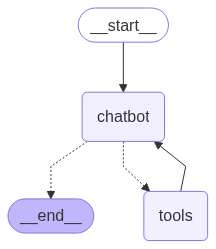

In [14]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result ["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


WITH MEMORY

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

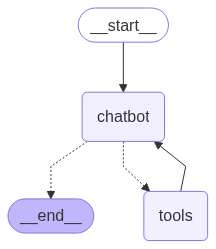

In [15]:
graph_builder = StateGraph(State)

llm = ChatDeepSeek(
    model="deepseek-chat",
)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result ["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='1cb9c23c-2473-429b-b3b3-8a952c06c9a8'), HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d468f006-c1d5-41c4-af95-8b7f5f7c9700')]}
{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='1cb9c23c-2473-429b-b3b3-8a952c06c9a8'), HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='d468f006-c1d5-41c4-af95-8b7f5f7c9700'), AIMessage(content="Hello! Nice to meet you. How can I help you today? I have access to search capabilities and can send push notifications if you need either of those services, or I'm happy to just chat with you about whatever you'd like to discuss.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 219, 'total_tokens': 269, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_toke

SAVE THE MEMORY IN SQL DATABASE:

In [19]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"

conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

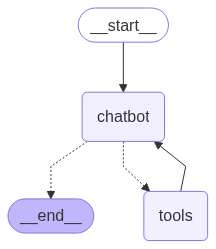

In [20]:
graph_builder = StateGraph(State)

llm = ChatDeepSeek(
    model="deepseek-chat",
)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result ["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()